#### Training a ResNet18 model on the dataset(face images) to classify the "Arched_Eyebrows" attribute. Applied appropriate data pre-processing . Evaluated the model by calculating precision, accuracy, F1 score, ROC curve, confusion matrix, and other relevant metrics. Did experiments with different hyperparameters and discussed about results. 

In [ ]:
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch

### Load the CSV files .
# Load CSV files
attr_file = 'face_image_attr.csv'
partition_file = 'face_image_eval_partition.csv'
image_folder = 'img_align_celeba'

attr_df = pd.read_csv(attr_file)
partition_df = pd.read_csv(partition_file)

# Filter only relevant columns
attr_df = attr_df[['image_id', 'Arched_Eyebrows']]
partition_df = partition_df[['image_id', 'partition']]

# Merge attributes and partition data
data_df = pd.merge(attr_df, partition_df, on='image_id')


# Create train, validation, and test splits based on partition given .
train_df = data_df[data_df['partition'] == 0]
val_df = data_df[data_df['partition'] == 1]
test_df = data_df[data_df['partition'] == 2]

# Remove the partition column
train_df = train_df.drop(columns=['partition'])
val_df = val_df.drop(columns=['partition'])
test_df = test_df.drop(columns=['partition'])

In [ ]:
# Custom Dataset class
class CelebADataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(1 if label == 1 else 0, dtype=torch.float32)
        
        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and data loaders
train_dataset = CelebADataset(train_df, image_folder, transform=transform)
val_dataset = CelebADataset(val_df, image_folder, transform=transform)
test_dataset = CelebADataset(test_df, image_folder, transform=transform)

# Change batch size from here .
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_curve, confusion_matrix, RocCurveDisplay, auc
import matplotlib.pyplot as plt
import copy
import numpy as np


# Load pre-trained ResNet18 and modify the last layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Binary classification


# Freeze all layers except the fully connected layer (Transfer Learning)
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True


In [ ]:
# Visulaize the model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

model = model.to(device)
lr = 0.001
num_epochs = 30
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.fc.parameters(), lr)

val_loss_ = []
train_loss_ = []
# Initialize the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

 
    best_model = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
 
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
 
            train_loss += loss.item() * images.size(0)

            
 
        train_loss = train_loss / len(train_loader.dataset)

        # Step the learning rate scheduler
        scheduler.step()
 
        # Validation
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
 
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = accuracy_score(val_labels, np.round(val_preds))

        val_loss_.append(val_loss)
        train_loss_.append(train_loss)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')



        if val_loss < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())


    # Load the best model before returning
    model.load_state_dict(best_model)
    return model, val_preds, val_labels
 
 
# Evaluation Function
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_preds = []
    all_labels = []
 
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
 
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
 
    precision = precision_score(all_labels, np.round(all_preds))
    accuracy = accuracy_score(all_labels, np.round(all_preds))
    f1 = f1_score(all_labels, np.round(all_preds))
 
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
 
    cm = confusion_matrix(all_labels, np.round(all_preds))
 
    return precision, accuracy, f1, fpr, tpr, roc_auc, cm
 

model, val_preds, val_labels = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


# Save model weights
torch.save(model.state_dict(), 'resnet18_arch_eyebrows.pth')
print("Model weights saved to resnet18_arch_eyebrows.pth")
# get the precision, accuracy, f1, fpr, tpr, roc_auc, cm for the best model
precision, accuracy, f1, fpr, tpr, roc_auc, cm = evaluate_model(model, test_loader)


Epoch 1/30
Train Loss: 0.4934, Val Loss: 0.4513, Val Accuracy: 0.7698
Epoch 2/30
Train Loss: 0.4591, Val Loss: 0.4455, Val Accuracy: 0.7782
Epoch 3/30
Train Loss: 0.4517, Val Loss: 0.4391, Val Accuracy: 0.7794
Epoch 4/30
Train Loss: 0.4461, Val Loss: 0.4387, Val Accuracy: 0.7769
Epoch 5/30
Train Loss: 0.4394, Val Loss: 0.4369, Val Accuracy: 0.7821
Epoch 6/30
Train Loss: 0.4353, Val Loss: 0.4365, Val Accuracy: 0.7788
Epoch 7/30
Train Loss: 0.4394, Val Loss: 0.4380, Val Accuracy: 0.7801
Epoch 8/30
Train Loss: 0.4368, Val Loss: 0.4363, Val Accuracy: 0.7830
Epoch 9/30
Train Loss: 0.4361, Val Loss: 0.4349, Val Accuracy: 0.7835
Epoch 10/30
Train Loss: 0.4269, Val Loss: 0.4472, Val Accuracy: 0.7776
Epoch 11/30
Train Loss: 0.4243, Val Loss: 0.4355, Val Accuracy: 0.7835
Epoch 12/30
Train Loss: 0.4230, Val Loss: 0.4403, Val Accuracy: 0.7807
Epoch 13/30
Train Loss: 0.4221, Val Loss: 0.4354, Val Accuracy: 0.7822
Epoch 14/30
Train Loss: 0.4237, Val Loss: 0.4356, Val Accuracy: 0.7807
Epoch 15/30
Tra

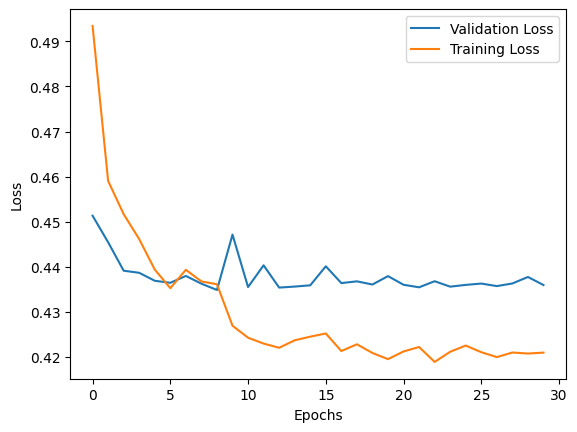

In [ ]:
# Use val_loss_ and train_loss_ to plot the training and validation loss against the number of epochs - taken from index .
plt.plot(val_loss_, label='Validation Loss')
plt.plot(train_loss_, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


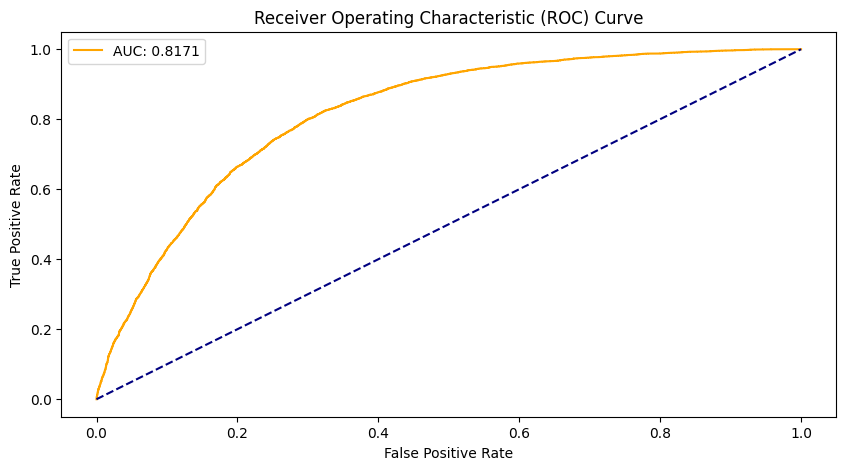

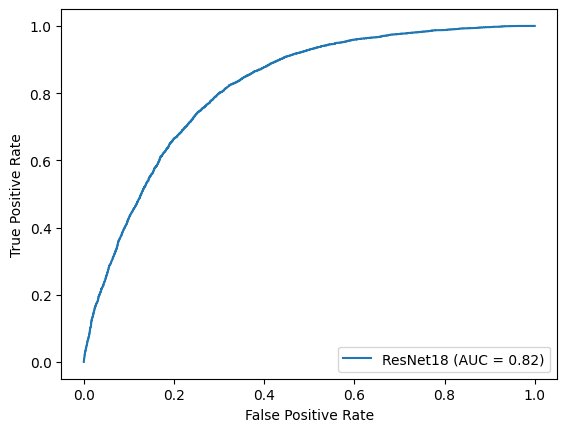

In [ ]:
#Make relevant plots for the model evaluation
# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='orange', label=f'AUC: {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ResNet18')
roc_display.plot()
plt.show()


### Captured a photo of myself, similar to the dataset mentioned above, and visualize the activation maps and filters at various layers of the model trained in part1. Then, conduct an occlusion experiment to examine the impact on the model's predictions.

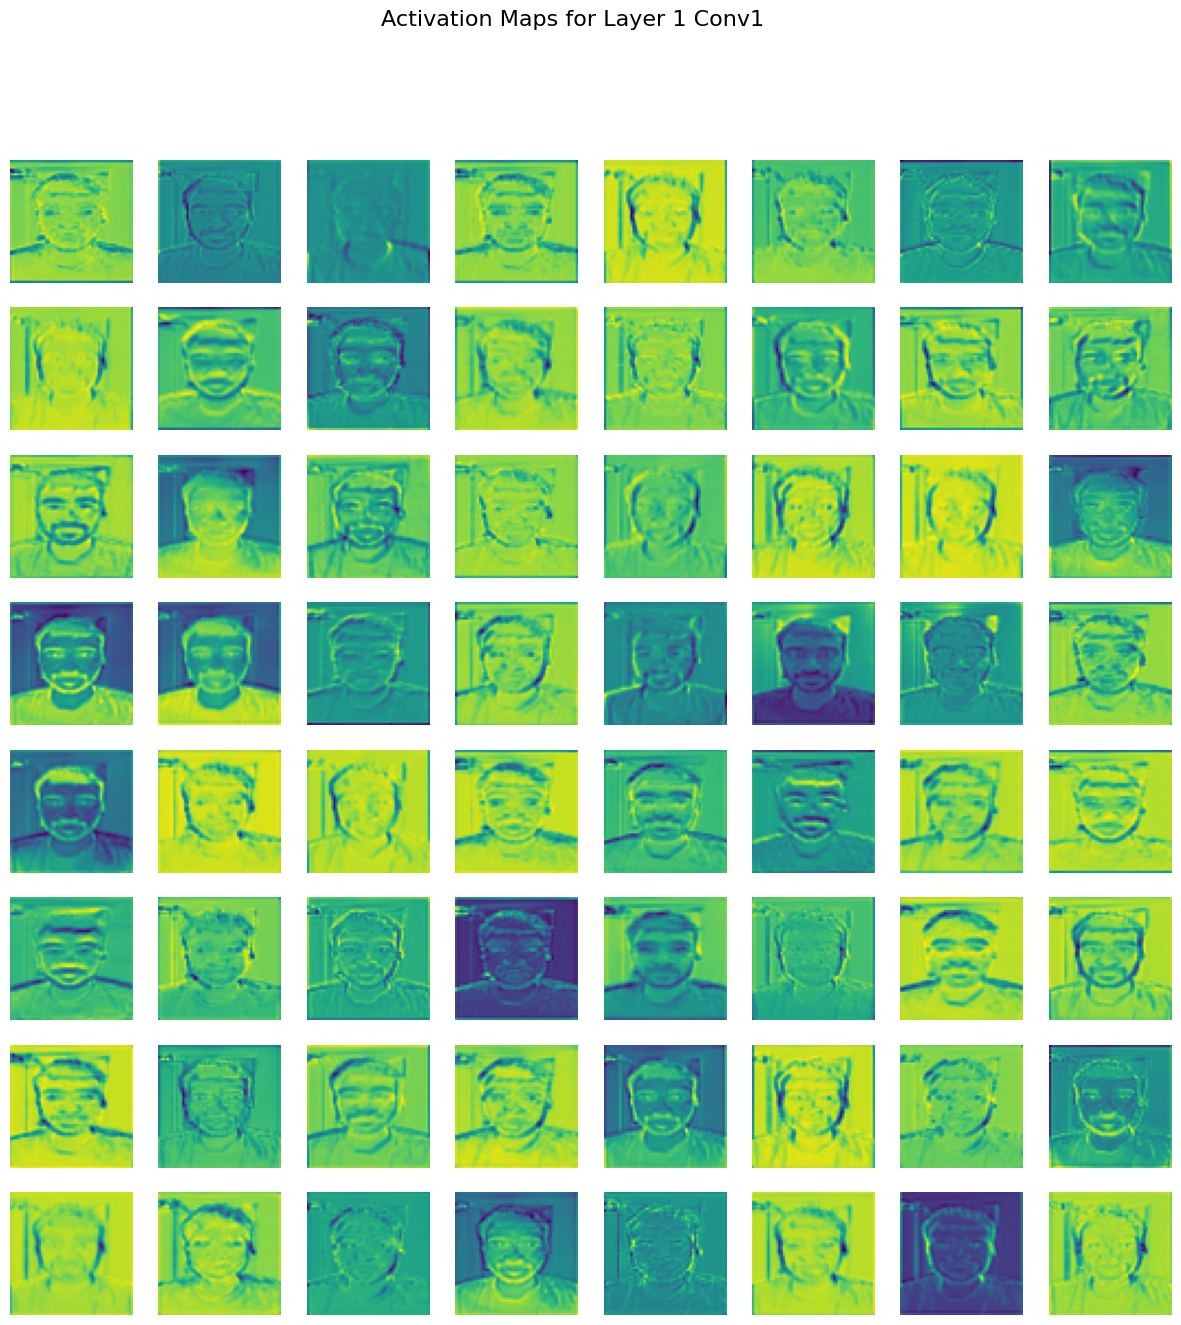

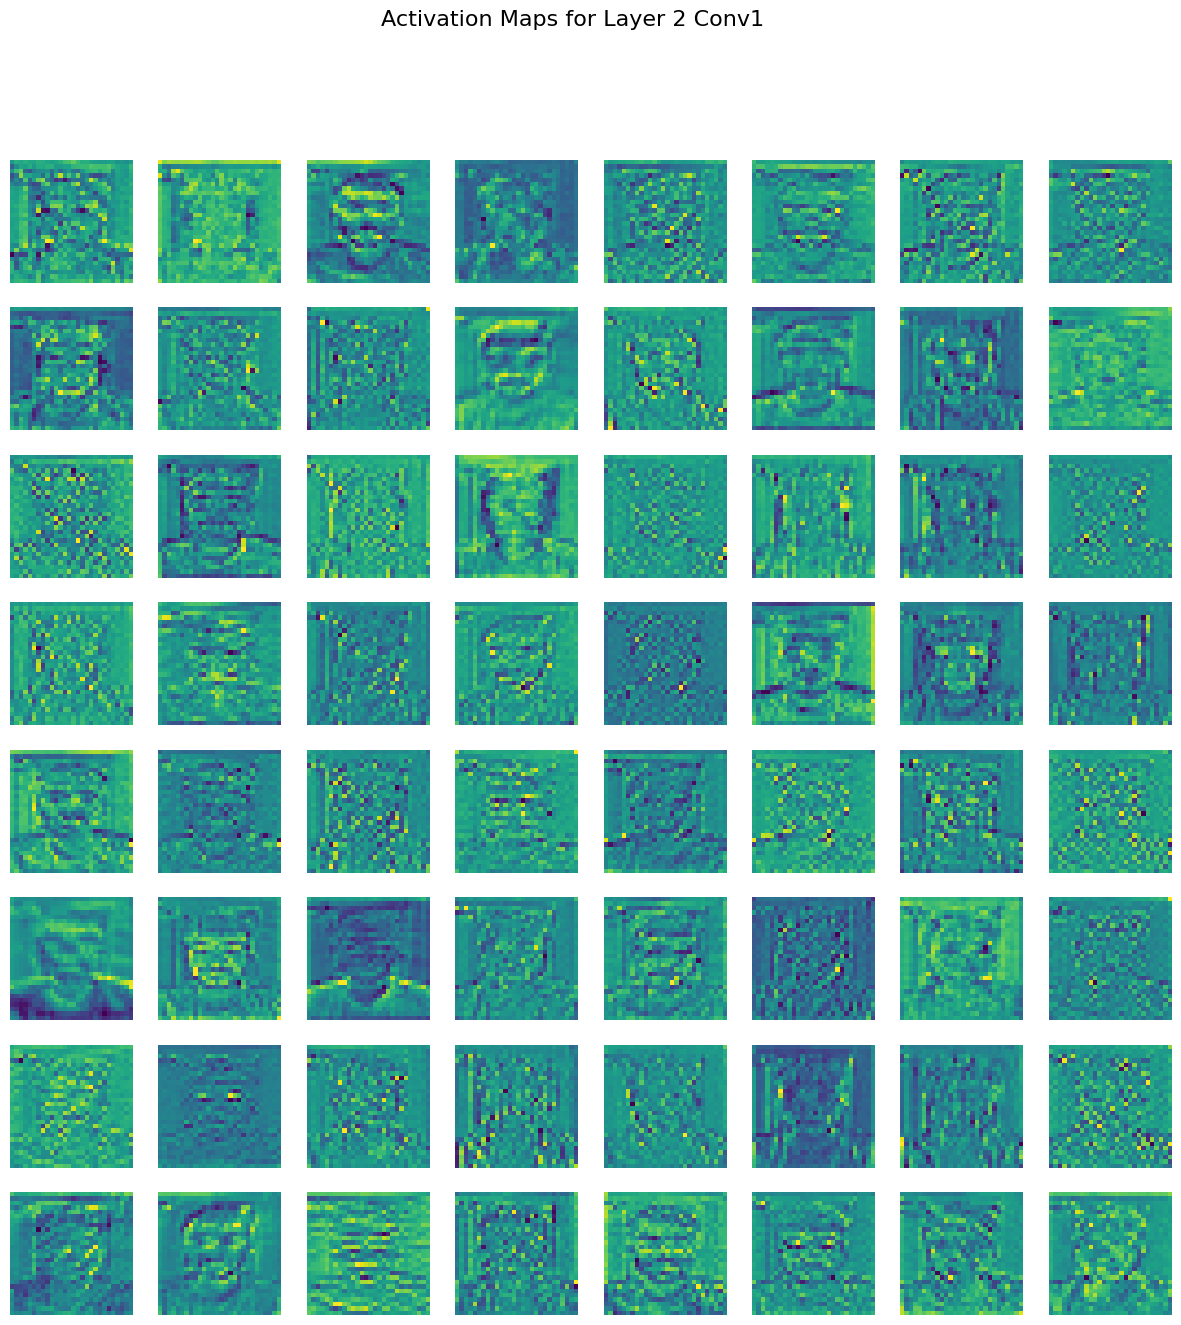

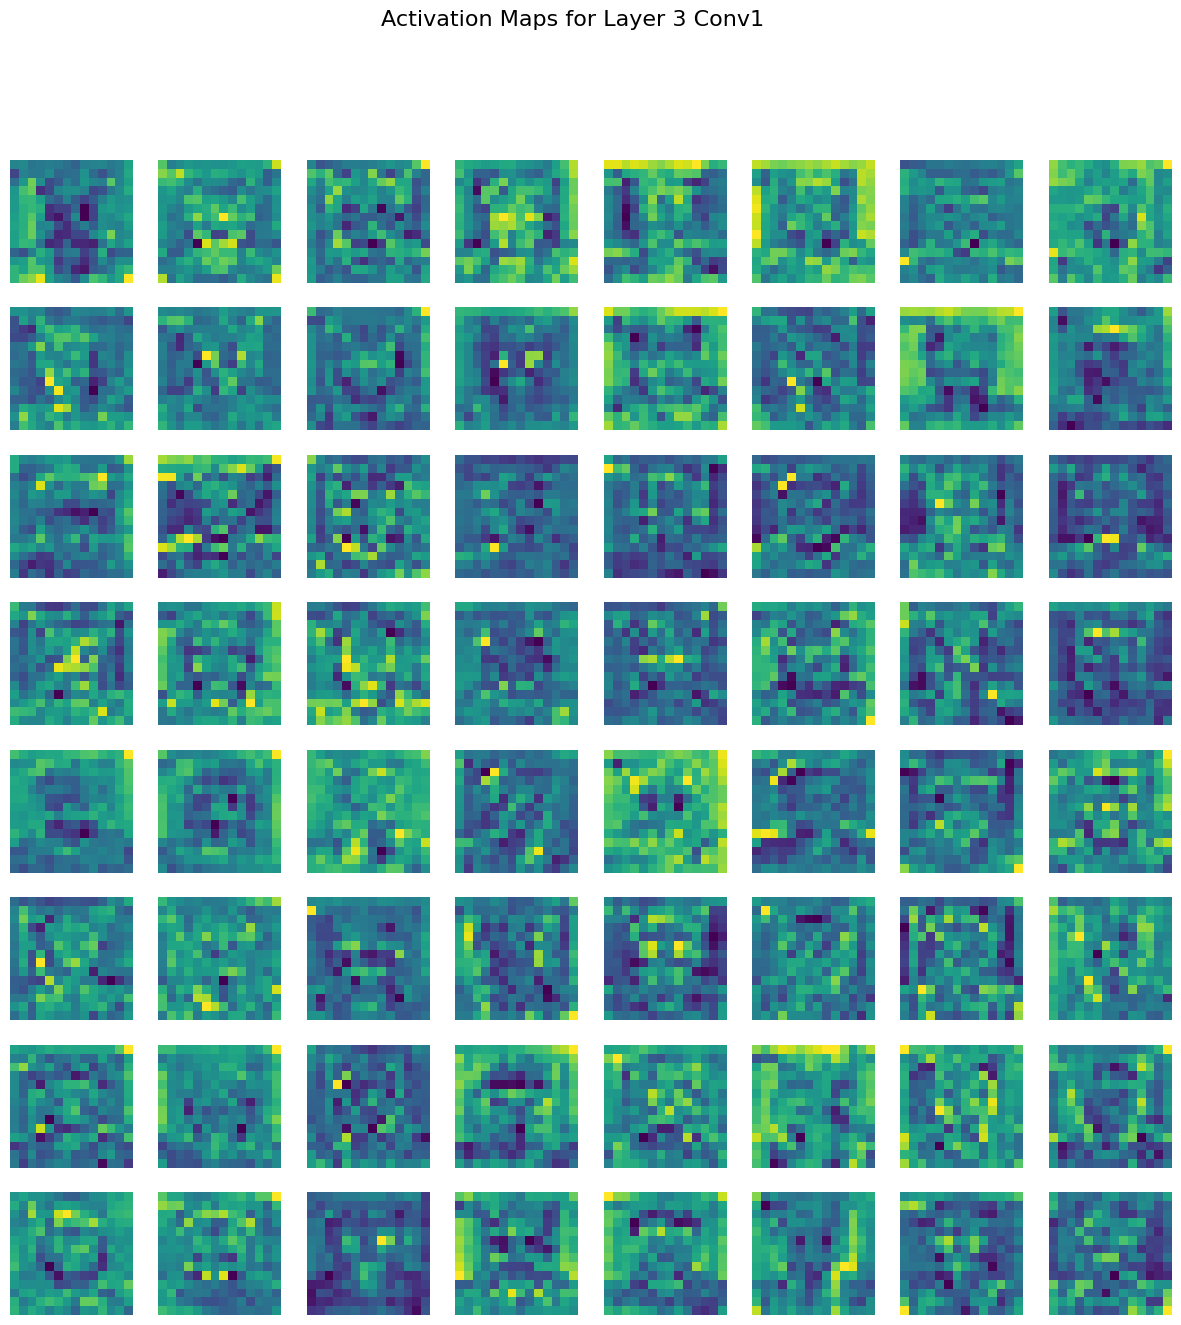

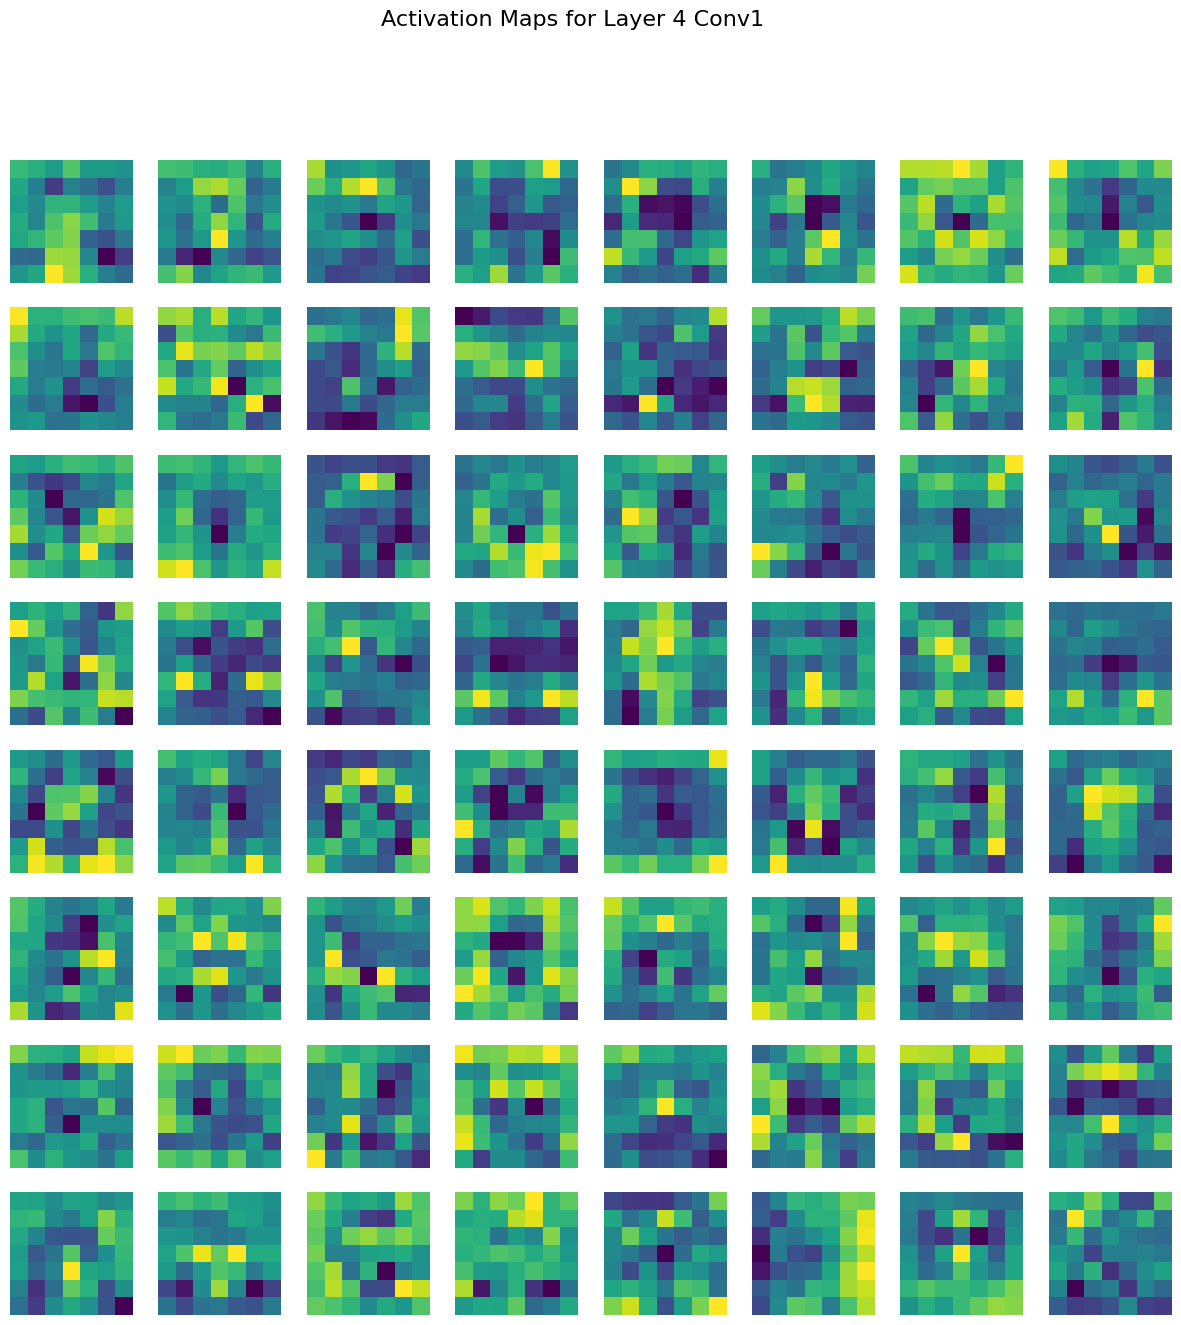

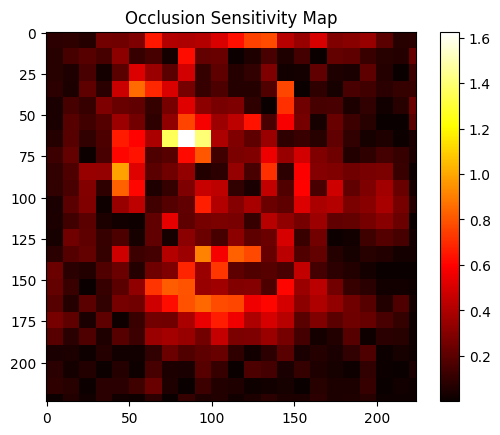

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

# Load the ResNet18 model (trained in Task 1)
model = models.resnet18()
model.fc = nn.Linear(512, 1)  # Assuming binary classification for 'Arched_Eyebrows'
model.load_state_dict(torch.load('resnet18_arch_eyebrows.pth'))  # Load the trained model
model.eval()

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load or capture an image
img = Image.open('BhanuKumar.jpg')  # Load a photo or capture from a webcam
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Forward pass to get activations
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

activations = {}
# Register hooks for specific layers
model.layer1[0].conv1.register_forward_hook(get_activation('layer1_conv1'))
model.layer2[0].conv1.register_forward_hook(get_activation('layer2_conv1'))
model.layer3[0].conv1.register_forward_hook(get_activation('layer3_conv1'))
model.layer4[0].conv1.register_forward_hook(get_activation('layer4_conv1'))

# Perform forward pass
output = model(img_tensor)

# Visualizing activation maps
def visualize_activation_maps(activation, layer_name):
    activation = activation.squeeze(0).cpu().numpy()  # Remove batch dimension
    num_filters = activation.shape[0]
    
    plt.figure(figsize=(15, 15))
    for i in range(min(num_filters, 64)):  # Visualize up to 64 filters
        plt.subplot(8, 8, i + 1)
        plt.imshow(activation[i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Activation Maps for {layer_name}', fontsize=16)
    plt.show()

# Visualize activations at various layers
visualize_activation_maps(activations['layer1_conv1'], 'Layer 1 Conv1')
visualize_activation_maps(activations['layer2_conv1'], 'Layer 2 Conv1')
visualize_activation_maps(activations['layer3_conv1'], 'Layer 3 Conv1')
visualize_activation_maps(activations['layer4_conv1'], 'Layer 4 Conv1')

# Occlusion Experiment
def occlusion_experiment(image_tensor, model, occlusion_size=30, stride=10):
    _, _, h, w = image_tensor.size()
    heatmap = np.zeros((h, w))
    
    original_prediction = model(image_tensor).item()
    
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            occluded_img = image_tensor.clone()
            occluded_img[:, :, y:y + occlusion_size, x:x + occlusion_size] = 0  # Apply occlusion (black square)
            prediction = model(occluded_img).item()
            heatmap[y:y + occlusion_size, x:x + occlusion_size] = abs(original_prediction - prediction)
    
    return heatmap

# Perform occlusion experiment
heatmap = occlusion_experiment(img_tensor, model)

# Visualize occlusion heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Occlusion Sensitivity Map')
plt.show()
